## Specifications

In [2]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'stix' 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import re

def clean_cell(x):
    x = x.replace("\\textbf{", "").replace("}", "").strip()
    if x in ["", "NA"]:
        return None
    try:
        return float(x)
    except:
        return None

def clean_model_name(name):
    return " ".join(name.replace("\\\\", "").split())

def parse_results_table(filepath):
    rows = []

    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()

            # Skip LaTeX formatting lines
            if (
                line.startswith("\\")
                or "toprule" in line
                or "midrule" in line
                or "bottomrule" in line
                or "tabular" in line
                or "Extraction" in line
                or "Model &" in line
            ):
                continue

            if "&" not in line:
                continue

            parts = [p.strip() for p in line.split("&")]

            # Only keep rows that look like real data rows
            if len(parts) < 6:
                continue

            model = clean_model_name(parts[0])

            acc  = clean_cell(parts[1])
            prec = clean_cell(parts[2])
            rec  = clean_cell(parts[3])
            f1   = clean_cell(parts[4])
            val  = clean_cell(parts[5].replace("\\\\", ""))

            rows.append((model, acc, prec, rec, f1, val))

    df = pd.DataFrame(rows, columns=[
        "Model",
        "Extraction_Accuracy",
        "Precision",
        "Recall",
        "F1",
        "Value_Accuracy"
    ])

    return df


df_results = parse_results_table("results/results.tex")
df_results.head()


,Model,Extraction_Accuracy,Precision,Recall,F1,Value_Accuracy
0,Baseline RegEx,0.943,0.832,0.727,0.776,0.888
1,Mistral 0-S,0.915,0.648,0.799,0.714,0.893
2,Mistral F-S,0.886,0.575,0.627,0.600,0.903
3,Llama 0-S,0.948,0.769,0.872,0.817,0.885
4,Llama F-S,0.902,0.608,0.806,0.693,0.906


In [4]:
#Settings for figures
metrics = [
    "Extraction_Accuracy",
    "Precision",
    "Recall",
    "F1",
    "Value_Accuracy"
]

metric_titles = {
    "Extraction_Accuracy": "Extraction Accuracy",
    "Precision": "Extraction Precision",
    "Recall": "Extraction Recall",
    "F1": "Extraction F1 Score",
    "Value_Accuracy": "Value Accuracy"
}

prompt_list = ["0-shot", "F-shot", "F-shot Implausible"]

titles = [
    "Extraction Accuracy",
    "Extraction Precision",
    "Extraction Recall",
    "Extraction F1 Score",
    "Value Accuracy"
]

colors = {"Mistral": "#4C72B0", 
          "Llama": "#55A868", 
          "GPT-OSS": "#C44E52", 
          "MedLlama": "#CCB974",
          "MedGemma": "#8172B3",
          "RegEx": "#999999"}

markers = {"Mistral": "o", 
           "Llama": "s", 
           "GPT-OSS": "D", 
           "MedLlama": "v",
           "MedGemma": "^"}

linestyles = {"0-shot": "solid", 
              "F-shot": "dashed", 
              "F-shot Implausible": "dotted"}


model_size_dict = {
    "Mistral": 7,
    "Llama": 8,
    "GPT-OSS": 20,    
    "MedLlama": 8,
    "MedGemma": 4}


In [5]:
#Prepare data for plotting
def get_prompt(name):
    if "Implausible" in name:
        return "F-shot Implausible"
    elif "F-S" in name:
        return "F-shot"
    elif "0-S" in name:
        return "0-shot"
    return None

def get_contraint(name):
    if "Constrained" in name:
        return 1
    return 0

def get_REGEX(name):
    if "RegEx" in name:
        return 1
    return 0


def get_medical(name):
    if "MedGemma" in name:
        return 1
    elif "MedLlama" in name:
        return 1
    return 0


families = ["Mistral", "Llama", "GPT-OSS"]
def is_baseline(name):
    return any(name.startswith(m) for m in families) and "Constrained" not in name and "RegEx" not in name
    

def is_regex(name):
    return any(name.startswith(f) for f in families) and "+ RegEx" in name

    
def is_constraint(name):
    return any(name.startswith(f) for f in families) and "Constrained" in name and "RegEx" not in name

def is_constraint_regex(name):
    return any(name.startswith(f) for f in families) and "Constrained" in name and "+ RegEx" in name


df_results["Prompt"] = df_results["Model"].apply(get_prompt)
df_results["Medical"] = df_results["Model"].apply(get_medical)
df_results["Constrained"] = df_results["Model"].apply(get_contraint)
df_results["RegEx"] = df_results["Model"].apply(get_REGEX)
df_results["Family"] = df_results["Model"].str.split().str[0]

print(df_results)

                                                Model  Extraction_Accuracy  \
0                                      Baseline RegEx                0.943   
1                                         Mistral 0-S                0.915   
2                                         Mistral F-S                0.886   
3                                           Llama 0-S                0.948   
4                                           Llama F-S                0.902   
5                                         GPT-OSS 0-S                0.819   
6                                         GPT-OSS F-S                0.968   
7                      Mistral F-S Implausible values                0.806   
8                        Llama F-S Implausible values                0.944   
9                      GPT-OSS F-S Implausible values                0.968   
10                                Mistral 0-S + RegEx                0.932   
11                                Mistral F-S + RegEx           

## Plots for General models


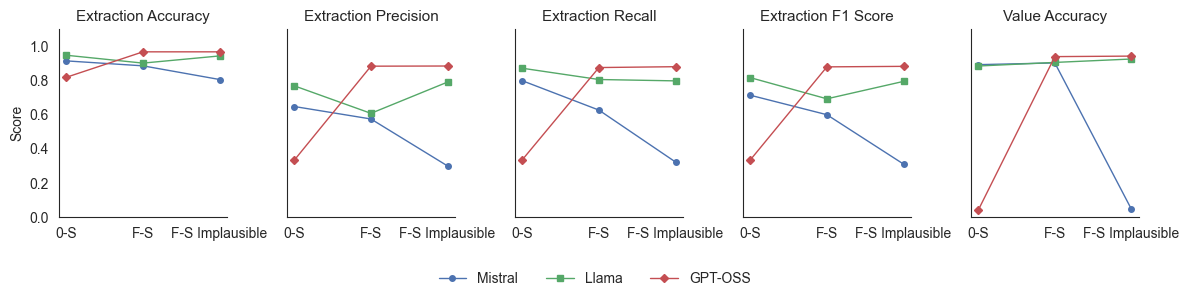

In [6]:
sns.set_style("white")

df_base = df_results[df_results["Model"].apply(is_baseline)].copy()

df_base = df_base[df_base["Prompt"].notna()]
df_base["Family"] = df_base["Model"].str.split().str[0]

prompt_order = ["0-shot", "F-shot", "F-shot Implausible"]
df_base["Prompt"] = pd.Categorical(df_base["Prompt"], prompt_order)
x_pos = {p: i for i, p in enumerate(prompt_order)}
df_base["x"] = df_base["Prompt"].map(x_pos)


fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharey=True)

display_labels = ["0-S", "F-S", "F-S Implausible"]
baseline_models = ["Mistral", "Llama", "GPT-OSS"]

for ax, metric, title in zip(axes, metrics, titles):

    for model in baseline_models:
        sub = df_base[df_base["Family"] == model].sort_values("x")

        ax.plot(
            sub["x"],
            sub[metric],
            marker=markers[model],
            markersize=4,
            linewidth=1,
            label=model,
            color=colors[model]
        )

        # point labels - I find it confusing, but can re-enable if needed
        #for _, row in sub.iterrows():
        #    ax.text(row["x"], row[metric] + 0.02,
        #            f"{row[metric]:.2f}",
        #            ha='right', fontsize=8)

    ax.set_xticks(range(len(prompt_order)))
    ax.set_xticklabels(display_labels)# , rotation=20)
    ax.set_title(title, fontsize=11)
    ax.set_ylim(0, 1.1)
    sns.despine(ax=ax)

axes[0].set_ylabel("Score")
fig.supxlabel("", fontsize=12)

# One legend for whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0.08, 1, 1])
sns.despine()
plt.savefig("figures/prompt_comparison.png", dpi=300)


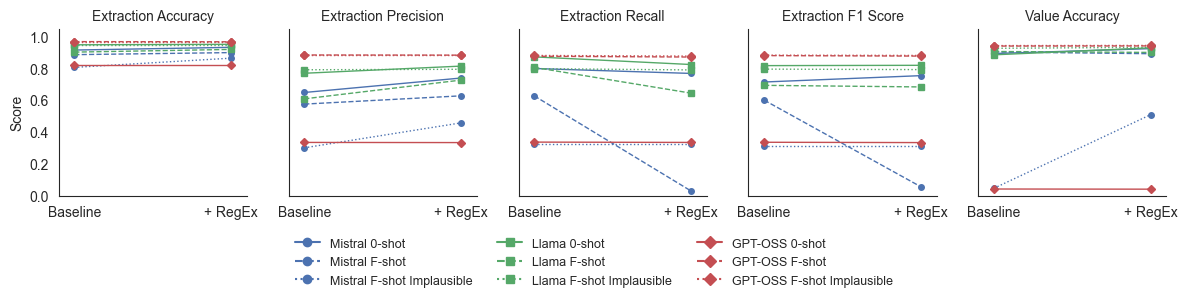

In [7]:
sns.set_style("white")

#Filter BASELINE and REGEX models
families = ["Mistral", "Llama", "GPT-OSS"]

df_base = df_results[df_results["Model"].apply(is_baseline)].copy()
df_regex = df_results[df_results["Model"].apply(is_regex)].copy()


for df in [df_base, df_regex]:
    df["Prompt"] = df["Model"].apply(get_prompt)
    df["Family"] = df["Model"].str.split().str[0]
    df["Prompt"] = pd.Categorical(df["Prompt"], prompt_list)


plot_data = []

for metric in metrics:
    for fam in families:
        for prompt in prompt_list:
            base_val = df_base[(df_base["Family"] == fam) & (df_base["Prompt"] == prompt)][metric].values[0]
            regex_val = df_regex[(df_regex["Family"] == fam) & (df_regex["Prompt"] == prompt)][metric].values[0]
            plot_data.append({
                "Family": fam,
                "Prompt": prompt,
                "x": 0,
                "Value": base_val,
                "Metric": metric
            })
            plot_data.append({
                "Family": fam,
                "Prompt": prompt,
                "x": 1,
                "Value": regex_val,
                "Metric": metric
            })

df_plot = pd.DataFrame(plot_data)

fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharey=True)

for ax, metric, title in zip(axes, metrics, titles):
    sub = df_plot[df_plot["Metric"] == metric]
    for fam in families:
        for prompt in prompt_list:
            vals = sub[(sub["Family"] == fam) & (sub["Prompt"] == prompt)].sort_values("x")
            ax.plot(
                vals["x"],
                vals["Value"],
                color=colors[fam],
                linestyle=linestyles[prompt],
                marker=markers[fam],
                markersize=4,
                linewidth=1,
                label=f"{fam} {prompt}"  # we'll handle legend later
            )
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Baseline", "+ RegEx"])
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(0, 1.05)
    ax.set_title(title, fontsize=10)
    sns.despine(ax=ax)

axes[0].set_ylabel("Score")

handles = []
labels_legend = []
for fam in families:
    for prompt in prompt_list:
        line = plt.Line2D([0], [0], color=colors[fam], marker=markers[fam], linestyle=linestyles[prompt])
        handles.append(line)
        labels_legend.append(f"{fam} {prompt}")

fig.legend(handles, labels_legend, loc="lower center", ncol=3, frameon=False, fontsize=9)

plt.tight_layout(rect=[0, 0.20, 1, 1])
plt.savefig("figures/adding_regex.png", dpi=300)


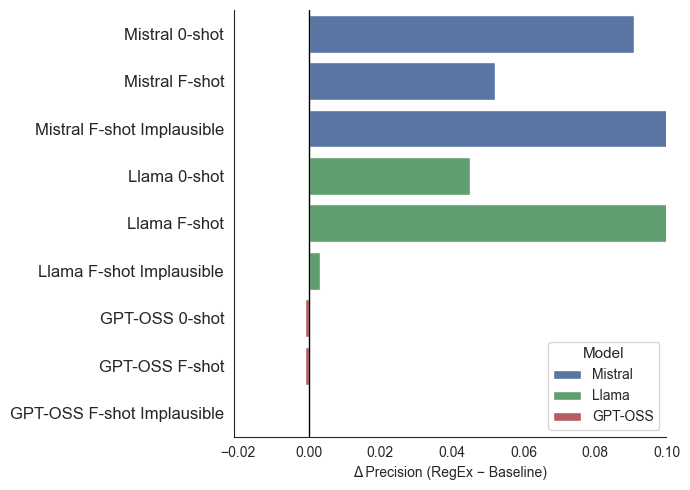

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

families = ["Mistral", "Llama", "GPT-OSS"]

# Filter BASELINE and REGEX models
df_base = df_results[df_results["Model"].apply(is_baseline)].copy()
df_regex = df_results[df_results["Model"].apply(is_regex)].copy()

for df in [df_base, df_regex]:
    df["Prompt"] = df["Model"].apply(get_prompt)
    df["Family"] = df["Model"].str.split().str[0]

# ---- Compute precision difference ----
plot_data = []

for fam in families:
    for prompt in prompt_list:
        base_val = df_base[
            (df_base["Family"] == fam) &
            (df_base["Prompt"] == prompt)
        ]["Precision"].values[0]

        regex_val = df_regex[
            (df_regex["Family"] == fam) &
            (df_regex["Prompt"] == prompt)
        ]["Precision"].values[0]

        plot_data.append({
            "ModelSetup": f"{fam} {prompt}",
            "Family": fam,
            "Prompt": prompt,
            "DeltaPrecision": regex_val - base_val
        })

df_plot = pd.DataFrame(plot_data)

# ---- Define strict order ----
ordered_labels = []
for fam in families:
    for prompt in prompt_list:
        ordered_labels.append(f"{fam} {prompt}")

df_plot["ModelSetup"] = pd.Categorical(
    df_plot["ModelSetup"],
    categories=ordered_labels,
    ordered=True
)

df_plot = df_plot.sort_values("ModelSetup")

# ---- Plot ----
plt.figure(figsize=(7, 5))

sns.barplot(
    data=df_plot,
    y="ModelSetup",
    x="DeltaPrecision",
    hue="Family",
    palette=colors,
    dodge=False
)

plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Δ Precision (RegEx − Baseline)")
plt.ylabel("")
plt.xlim(-0.021, 0.1)  # adjust if needed
plt.tick_params(axis='y', labelsize=12)
sns.despine()

# ---- Add percentage annotations ----
for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        ax.text(
            width + (0.002 if width >= 0 else -0.005),
            bar.get_y() + bar.get_height() / 2,
            f"{width*100:.1f}%",
            va='center',
            ha='left' if width >= 0 else 'right',
            fontsize=9
        )

# Clean legend
plt.legend(title="Model", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.savefig("figures/precision_regex_delta_horizontal.png", dpi=300)
#plt.show()

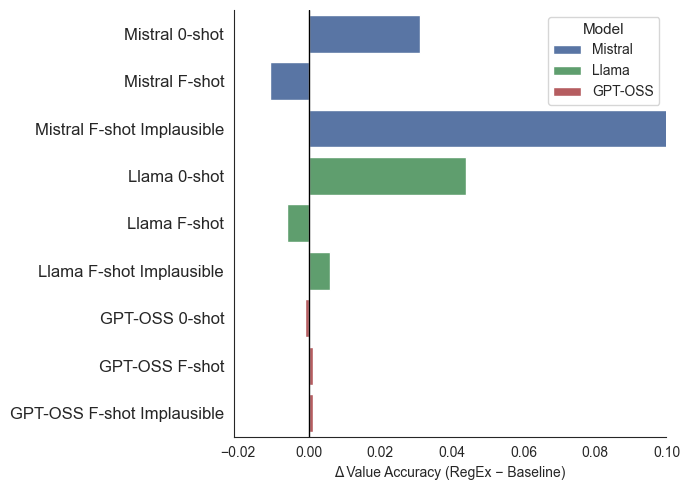

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

families = ["Mistral", "Llama", "GPT-OSS"]

# Filter BASELINE and REGEX models
df_base = df_results[df_results["Model"].apply(is_baseline)].copy()
df_regex = df_results[df_results["Model"].apply(is_regex)].copy()

for df in [df_base, df_regex]:
    df["Prompt"] = df["Model"].apply(get_prompt)
    df["Family"] = df["Model"].str.split().str[0]

# ---- Compute precision difference ----
plot_data = []

for fam in families:
    for prompt in prompt_list:
        base_val = df_base[
            (df_base["Family"] == fam) &
            (df_base["Prompt"] == prompt)
        ]["Value_Accuracy"].values[0]

        regex_val = df_regex[
            (df_regex["Family"] == fam) &
            (df_regex["Prompt"] == prompt)
        ]["Value_Accuracy"].values[0]

        plot_data.append({
            "ModelSetup": f"{fam} {prompt}",
            "Family": fam,
            "Prompt": prompt,
            "DeltaValAcc": regex_val - base_val
        })

df_plot = pd.DataFrame(plot_data)

# ---- Define strict order ----
ordered_labels = []
for fam in families:
    for prompt in prompt_list:
        ordered_labels.append(f"{fam} {prompt}")

df_plot["ModelSetup"] = pd.Categorical(
    df_plot["ModelSetup"],
    categories=ordered_labels,
    ordered=True
)

df_plot = df_plot.sort_values("ModelSetup")

# ---- Plot ----
plt.figure(figsize=(7, 5))

sns.barplot(
    data=df_plot,
    y="ModelSetup",
    x="DeltaValAcc",
    hue="Family",
    palette=colors,
    dodge=False
)

plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Δ Value Accuracy (RegEx − Baseline)")
plt.ylabel("")
plt.xlim(-0.021, 0.1)  # adjust if needed
plt.tick_params(axis='y', labelsize=12)
sns.despine()

# ---- Add percentage annotations ----
for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        ax.text(
            width + (0.002 if width >= 0 else -0.005),
            bar.get_y() + bar.get_height() / 2,
            f"{width*100:.1f}%",
            va='center',
            ha='left' if width >= 0 else 'right',
            fontsize=9
        )

# Clean legend
plt.legend(title="Model", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.savefig("figures/value_acc_regex_delta_horizontal.png", dpi=300)
#plt.show()

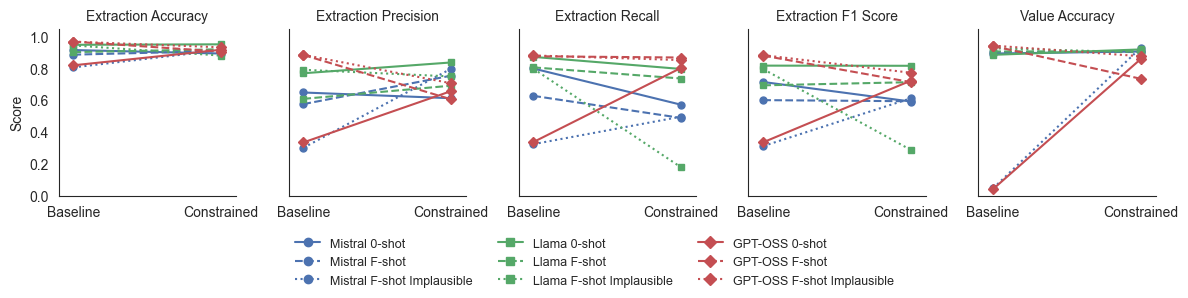

In [10]:
sns.set_style("white")


df_base = df_results[df_results["Model"].apply(is_baseline)].copy()
df_guid = df_results[df_results["Model"].apply(is_constraint)].copy()

plot_data = []

for metric in metrics:
    for fam in families:
        for prompt in prompt_list:
            base_val = df_base[(df_base["Family"] == fam) & (df_base["Prompt"] == prompt)][metric].values[0]
            guid_val = df_guid[(df_guid["Family"] == fam) & (df_guid["Prompt"] == prompt)][metric].values[0]
            plot_data.append({"Family": fam, "Prompt": prompt, "x": 0, "Value": base_val, "Metric": metric})
            plot_data.append({"Family": fam, "Prompt": prompt, "x": 1, "Value": guid_val, "Metric": metric})

df_plot = pd.DataFrame(plot_data)


fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharey=True)


for ax, metric, title in zip(axes, metrics, titles):
    sub = df_plot[df_plot["Metric"] == metric]
    for fam in families:
        for prompt in prompt_list:
            vals = sub[(sub["Family"] == fam) & (sub["Prompt"] == prompt)].sort_values("x")
            ax.plot(
                vals["x"],
                vals["Value"],
                color=colors[fam],
                linestyle=linestyles[prompt],
                marker=markers[fam],
                markersize=5,
                linewidth=1.5,
                label=f"{fam} {prompt}"
            )
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Baseline", "Constrained"])
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(0, 1.05)
    ax.set_title(title, fontsize=10)
    sns.despine(ax=ax)

axes[0].set_ylabel("Score")


handles = []
labels_legend = []
for fam in families:
    for prompt in prompt_list:
        line = plt.Line2D([0], [0], color=colors[fam], marker=markers[fam], linestyle=linestyles[prompt])
        handles.append(line)
        labels_legend.append(f"{fam} {prompt}")

fig.legend(handles, labels_legend, loc="lower center", ncol=3, frameon=False, fontsize=9)

plt.tight_layout(rect=[0, 0.20, 1, 1])
plt.savefig("figures/adding_guidance.png", dpi=300)
plt.show()


(9, 11)
(9, 11)
(9, 11)


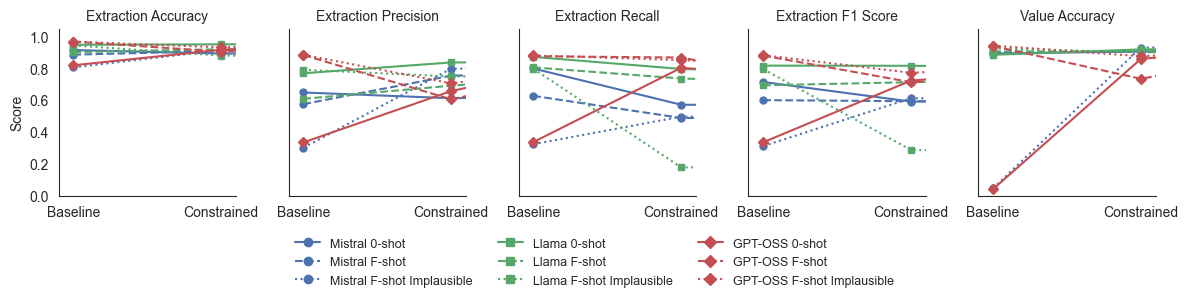

In [11]:
sns.set_style("white")

df_base = df_results[df_results["Model"].apply(is_baseline)].copy()
df_guid = df_results[df_results["Model"].apply(is_constraint)].copy()
df_guid_regex = df_results[df_results["Model"].apply(is_constraint_regex)].copy()
print(df_base.shape)
print(df_guid.shape)
print(df_guid_regex.shape)

plot_data = []

for metric in metrics:
    for fam in families:
        for prompt in prompt_list:
            base_val = df_base[(df_base["Family"] == fam) & (df_base["Prompt"] == prompt)][metric].values[0]
            guid_val = df_guid[(df_guid["Family"] == fam) & (df_guid["Prompt"] == prompt)][metric].values[0]
            guid_regex_val = df_guid_regex[(df_guid_regex["Family"] == fam) & (df_guid_regex["Prompt"] == prompt)][metric].values[0]
            plot_data.append({"Family": fam, "Prompt": prompt, "x": 0, "Value": base_val, "Metric": metric})
            plot_data.append({"Family": fam, "Prompt": prompt, "x": 1, "Value": guid_val, "Metric": metric})
            plot_data.append({"Family": fam, "Prompt": prompt, "x": 2, "Value": guid_regex_val, "Metric": metric})

df_plot = pd.DataFrame(plot_data)

fig, axes = plt.subplots(1, 5, figsize=(12, 3), sharey=True)
for ax, metric, title in zip(axes, metrics, titles):
    sub = df_plot[df_plot["Metric"] == metric]
    for fam in families:
        for prompt in prompt_list:
            vals = sub[(sub["Family"] == fam) & (sub["Prompt"] == prompt)].sort_values("x")
            ax.plot(
                vals["x"],
                vals["Value"],
                color=colors[fam],
                linestyle=linestyles[prompt],
                marker=markers[fam],
                markersize=5,
                linewidth=1.5,
                label=f"{fam} {prompt}"
            )
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Baseline", "Constrained"])
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(0, 1.05)
    ax.set_title(title, fontsize=10)
    sns.despine(ax=ax)

axes[0].set_ylabel("Score")


handles = []
labels_legend = []
for fam in families:
    for prompt in prompt_list:
        line = plt.Line2D([0], [0], color=colors[fam], marker=markers[fam], linestyle=linestyles[prompt])
        handles.append(line)
        labels_legend.append(f"{fam} {prompt}")

fig.legend(handles, labels_legend, loc="lower center", ncol=3, frameon=False, fontsize=9)

plt.tight_layout(rect=[0, 0.20, 1, 1])
plt.savefig("figures/baseline_guidance_regex+guidance.png", dpi=300)


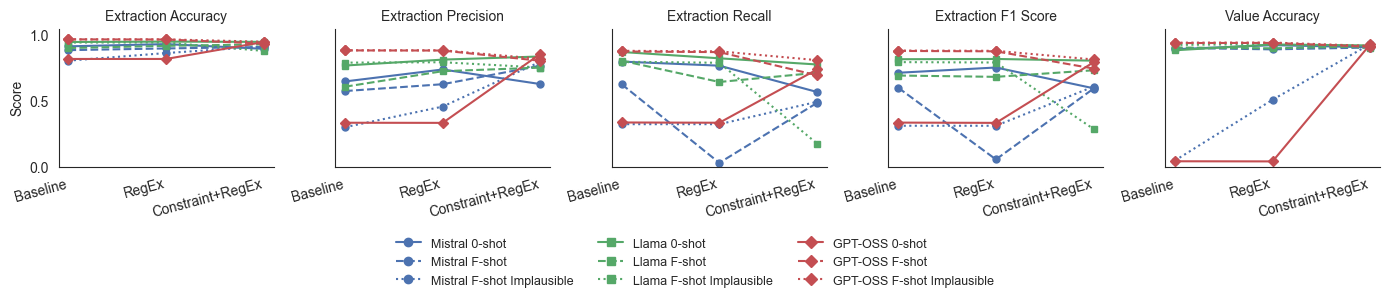

In [12]:
sns.set_style("white")


plot_data = []

x_mapping = {
    "Baseline": 0,
    "Baseline + REGEX": 1,
    "Guided + REGEX": 2
}

for metric in metrics:
    for fam in families:
        for prompt in prompt_list:
            base_val = df_base[(df_base["Family"] == fam) & (df_base["Prompt"] == prompt)][metric].values[0]
            regex_val = df_regex[(df_regex["Family"] == fam) & (df_regex["Prompt"] == prompt)][metric].values[0]
            guid_regex_val = df_guid_regex[(df_guid_regex["Family"] == fam) & (df_guid_regex["Prompt"] == prompt)][metric].values[0]

            plot_data.append({"Family": fam, "Prompt": prompt, "x": 0, "Value": base_val, "Metric": metric})
            plot_data.append({"Family": fam, "Prompt": prompt, "x": 1, "Value": regex_val, "Metric": metric})
            plot_data.append({"Family": fam, "Prompt": prompt, "x": 2, "Value": guid_regex_val, "Metric": metric})

df_plot = pd.DataFrame(plot_data)


fig, axes = plt.subplots(1, 5, figsize=(14, 3), sharey=True)

for ax, metric, title in zip(axes, metrics, titles):
    sub = df_plot[df_plot["Metric"] == metric]
    for fam in families:
        for prompt in prompt_list:
            vals = sub[(sub["Family"] == fam) & (sub["Prompt"] == prompt)].sort_values("x")
            ax.plot(
                vals["x"],
                vals["Value"],
                color=colors[fam],
                linestyle=linestyles[prompt],
                marker=markers[fam],
                markersize=5,
                linewidth=1.5,
                label=f"{fam} {prompt}"
            )
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["Baseline", "RegEx", "Constraint+RegEx"], rotation=15, ha="right")
    ax.set_xlim(-0.1, 2.1)
    ax.set_ylim(0, 1.05)
    ax.set_title(title, fontsize=10)
    sns.despine(ax=ax)

axes[0].set_ylabel("Score")


handles = []
labels_legend = []
for fam in families:
    for prompt in prompt_list:
        line = plt.Line2D([0], [0], color=colors[fam], marker=markers[fam], linestyle=linestyles[prompt])
        handles.append(line)
        labels_legend.append(f"{fam} {prompt}")

fig.legend(handles, labels_legend, loc="lower center", ncol=3, frameon=False, fontsize=9)

plt.tight_layout(rect=[0, 0.20, 1, 1])
plt.savefig("figures/baseline_regex_regex+guidance.png", dpi=300)
plt.show()


##  Plots to include medical models

In [13]:
families = ["Mistral", "Llama", "GPT-OSS", "MedLlama", "MedGemma"]
prompts = ["0-shot", "F-shot"]

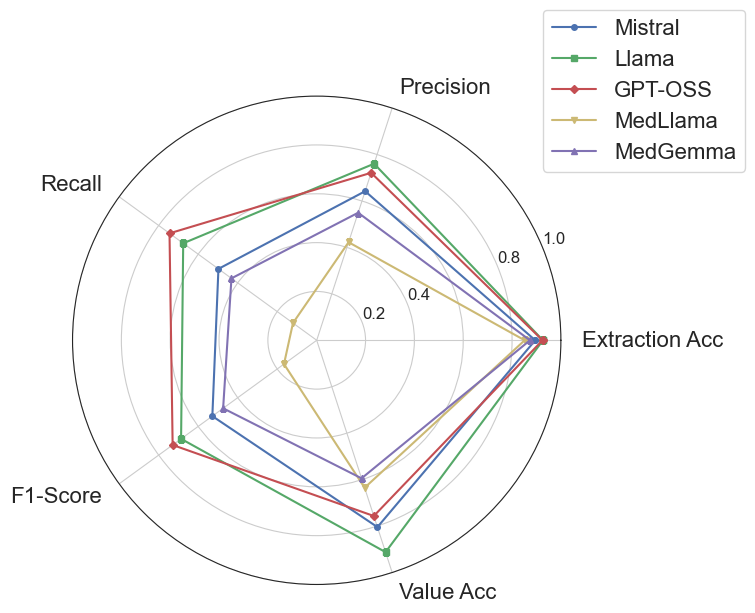

In [31]:
metrics = ["Extraction_Accuracy", "Precision", "Recall", "F1", "Value_Accuracy"]
metric_titles = [
    "Extraction Acc",
    "Precision",
    "Recall",
    "F1-Score",
    "Value Acc"
]

N = len(metrics)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

#Prepare dataframe
df_plot = df_results.copy()
df_plot["Family"] = df_plot["Model"].str.split().str[0]
df_family = df_plot.groupby("Family")[metrics].mean().reset_index()
legend_order = ["Mistral", "Llama", "GPT-OSS", "MedLlama", "MedGemma"]


plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

lines = {}

for fam in legend_order:
    if fam not in df_family["Family"].values:
        continue
        
    row = df_family[df_family["Family"] == fam].iloc[0]
    values = [row[m] for m in metrics]
    values += values[:1]

    line, = ax.plot(
        angles,
        values,
        linewidth=1.5,
        color=colors[fam],
        marker=markers[fam],
        markersize=4,
        label=fam
    )
    #ax.fill(angles, values, color=family_colors[fam], alpha=0.10)
    lines[fam] = line


ax.set_xticks(angles[:-1])
ax.set_xticklabels(metric_titles, fontsize=16)

# Move labels outward
ax.tick_params(axis='x', pad=5)

# Rotate labels to follow the circle nicely
for label, angle in zip(ax.get_xticklabels(), angles):
    angle_deg = np.degrees(angle)

    if angle_deg >= 90 and angle_deg <= 270:
        label.set_horizontalalignment('right')
    else:
        label.set_horizontalalignment('left')

    label.set_rotation(angle_deg - 90)

ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2","0.4","","0.8","1.0"], fontsize=12)

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1.2), fontsize=16)

plt.tight_layout()
plt.savefig("figures/radar_family_average.png", dpi=300)


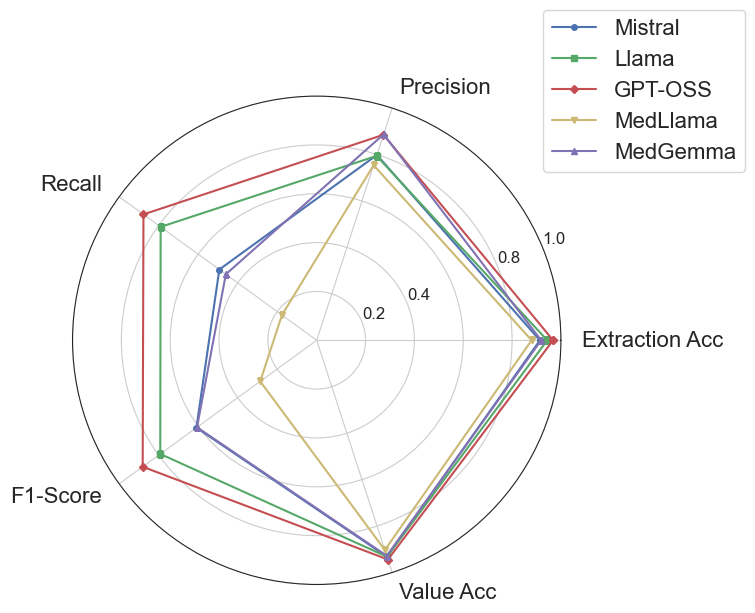

In [34]:
metrics = ["Extraction_Accuracy", "Precision", "Recall", "F1", "Value_Accuracy"]
metric_titles = [
    "Extraction Acc",
    "Precision",
    "Recall",
    "F1-Score",
    "Value Acc"
]

N = len(metrics)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

#Prepare dataframe
df_plot = df_results.copy()
df_plot["Family"] = df_plot["Model"].str.split().str[0]
# Model with best Value_Accuracy per family
best_metric = "Value_Accuracy" #"Precision" 
idx_best = df_plot.groupby("Family")[best_metric].idxmax()
df_family = df_plot.loc[idx_best].reset_index(drop=True)
legend_order = ["Mistral", "Llama", "GPT-OSS", "MedLlama", "MedGemma"]


plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

lines = {}

for fam in legend_order:
    if fam not in df_family["Family"].values:
        continue
        
    row = df_family[df_family["Family"] == fam].iloc[0]
    values = [row[m] for m in metrics]
    values += values[:1]

    line, = ax.plot(
        angles,
        values,
        linewidth=1.5,
        color=colors[fam],
        marker=markers[fam],
        markersize=4,
        label=fam
    )
    #ax.fill(angles, values, color=family_colors[fam], alpha=0.10)
    lines[fam] = line


ax.set_xticks(angles[:-1])
ax.set_xticklabels(metric_titles, fontsize=16)

# Move labels outward
ax.tick_params(axis='x', pad=5)

# Rotate labels to follow the circle nicely
for label, angle in zip(ax.get_xticklabels(), angles):
    angle_deg = np.degrees(angle)

    if angle_deg >= 90 and angle_deg <= 270:
        label.set_horizontalalignment('right')
    else:
        label.set_horizontalalignment('left')

    label.set_rotation(angle_deg - 90)

ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2","0.4","","0.8","1.0"], fontsize=12)

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1.2), fontsize=16)

plt.tight_layout()
plt.savefig("figures/radar_family_best_val_acc.png", dpi=300)

In [16]:
df_results.columns

Index(['Model', 'Extraction_Accuracy', 'Precision', 'Recall', 'F1',
       'Value_Accuracy', 'Prompt', 'Medical', 'Constrained', 'RegEx',
       'Family'],
      dtype='object')

## Ablation for GPT only

In [17]:
# Filter for GPT-OSS models
df_gptoss = df_results[df_results["Family"] == "GPT-OSS"]
df_gptoss

,Model,Extraction_Accuracy,Precision,Recall,F1,Value_Accuracy,Prompt,Medical,Constrained,RegEx,Family
5,GPT-OSS 0-S,0.819,0.334,0.336,0.335,0.041,0-shot,0,0,0,GPT-OSS
6,GPT-OSS F-S,0.968,0.884,0.876,0.880,0.940,F-shot,0,0,0,GPT-OSS
9,GPT-OSS F-S Implausible values,0.968,0.885,0.881,0.883,0.943,F-shot Implausible,0,0,0,GPT-OSS
14,GPT-OSS 0-S + RegEx,0.819,0.333,0.334,0.333,0.040,0-shot,0,0,1,GPT-OSS
15,GPT-OSS F-S + RegEx,0.967,0.883,0.871,0.877,0.941,F-shot,0,0,1,GPT-OSS
18,GPT-OSS F-S Implausible values + RegEx,0.968,0.885,0.877,0.881,0.944,F-shot Implausible,0,0,1,GPT-OSS
23,GPT-OSS 0-S Constrained,0.917,0.657,0.803,0.723,0.860,0-shot,0,1,0,GPT-OSS
24,GPT-OSS F-S Constrained,0.905,0.605,0.868,0.713,0.734,F-shot,0,1,0,GPT-OSS
27,GPT-OSS F-S Implausible values Constrained,0.932,0.706,0.852,0.772,0.876,F-shot Implausible,0,1,0,GPT-OSS
32,GPT-OSS 0-S Constrained + RegEx,0.948,0.858,0.739,0.794,0.930,0-shot,0,1,1,GPT-OSS


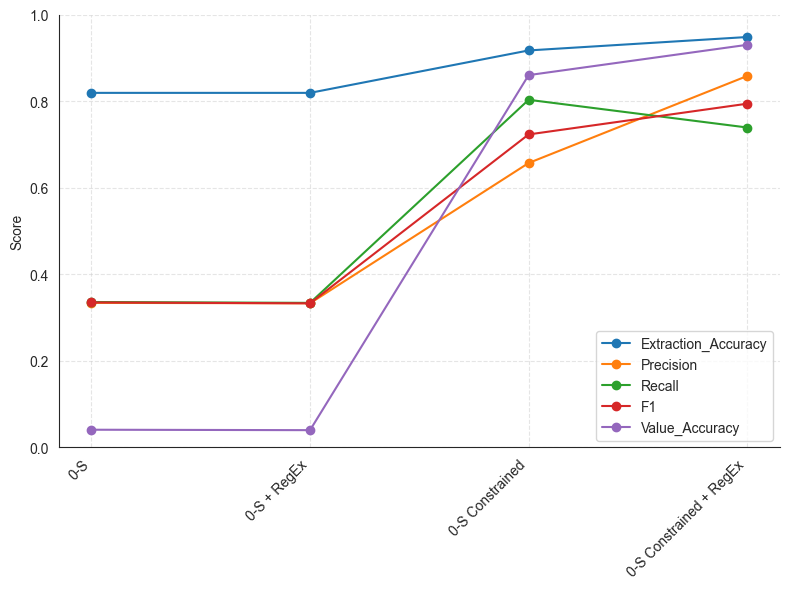

In [18]:
# Expanded order covering all setups from your table
order = [
    "0-S",
    "0-S + RegEx",
    "0-S Constrained",
    "0-S Constrained + RegEx",
    # "F-S",
    # "F-S + RegEx",
    # "F-S Constrained",
    # "F-S Constrained + RegEx",
    # "F-S + Implausible",
    # "F-S + Implausible + RegEx",
    # "F-S + Implausible Constrained",
    # "F-S + Implausible Constrained + RegEx"
]

# Map each order name to the corresponding row in df_gptoss
def map_order(name):
    if name == "0-S":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 0)]
    elif name == "F-S":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 0)]
    elif name == "F-S + Implausible":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 0)]
    elif name == "0-S + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 1)]
    elif name == "F-S + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 1) ]
    elif name == "F-S + Implausible + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 1) ]
    elif name == "0-S Constrained":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 0) ]
    elif name == "F-S Constrained":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 0) ]
    elif name == "F-S + Implausible Constrained":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 0) ]
    elif name == "0-S Constrained + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 1)]
    elif name == "F-S Constrained + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 1)]
    elif name == "F-S + Implausible Constrained + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 1)]
    return pd.DataFrame()

# Prepare plotting data
plot_data = {metric: [] for metric in metrics}
for cond in order:
    subset = map_order(cond)
    for metric in metrics:
        if not subset.empty:
            plot_data[metric].append(subset[metric].values[0])
        else:
            plot_data[metric].append(None)

# Plot ablation results
plt.figure(figsize=(8, 6))
for metric in metrics:
    plt.plot(order, plot_data[metric], marker='o', label=metric)

plt.title("")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
sns.despine()
plt.show()


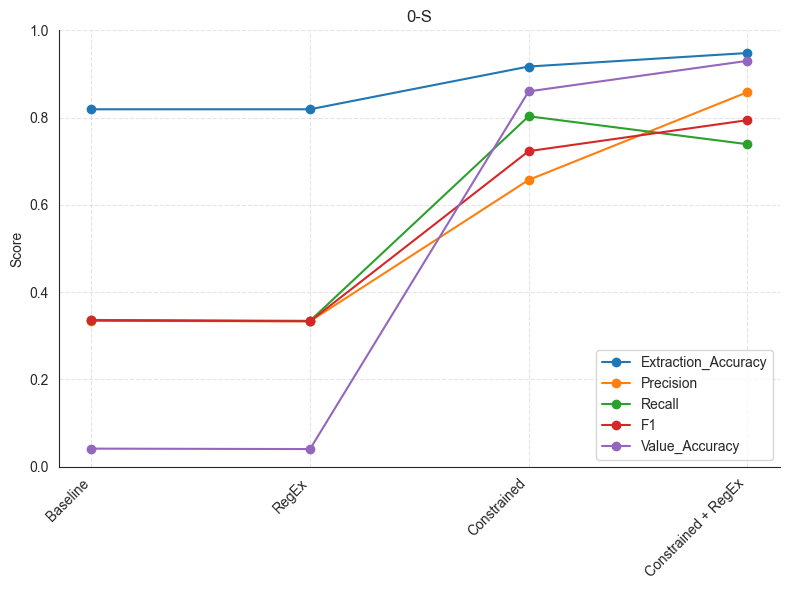

In [19]:
# Expanded order covering all setups from your table
order = [
    "Baseline",
    "RegEx",
    "Constrained",
    "Constrained + RegEx",
]

# Map each order name to the corresponding row in df_gptoss
def map_order(name):
    if name == "Baseline":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 0)]
    elif name == "F-S":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 0)]
    elif name == "F-S + Implausible":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 0)]
    elif name == "RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 1)]
    elif name == "F-S + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 1) ]
    elif name == "F-S + Implausible + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 1) ]
    elif name == "Constrained":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 0) ]
    elif name == "F-S Constrained":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 0) ]
    elif name == "F-S + Implausible Constrained":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 0) ]
    elif name == "Constrained + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 1)]
    elif name == "F-S Constrained + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 1)]
    elif name == "F-S + Implausible Constrained + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 1)]
    return pd.DataFrame()

# Prepare plotting data
plot_data = {metric: [] for metric in metrics}
for cond in order:
    subset = map_order(cond)
    for metric in metrics:
        if not subset.empty:
            plot_data[metric].append(subset[metric].values[0])
        else:
            plot_data[metric].append(None)

# Plot ablation results
plt.figure(figsize=(8, 6))
for metric in metrics:
    plt.plot(order, plot_data[metric], marker='o', label=metric)

plt.title("0-S")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
sns.despine()
plt.savefig("figures/gpt_ablation_0-S")


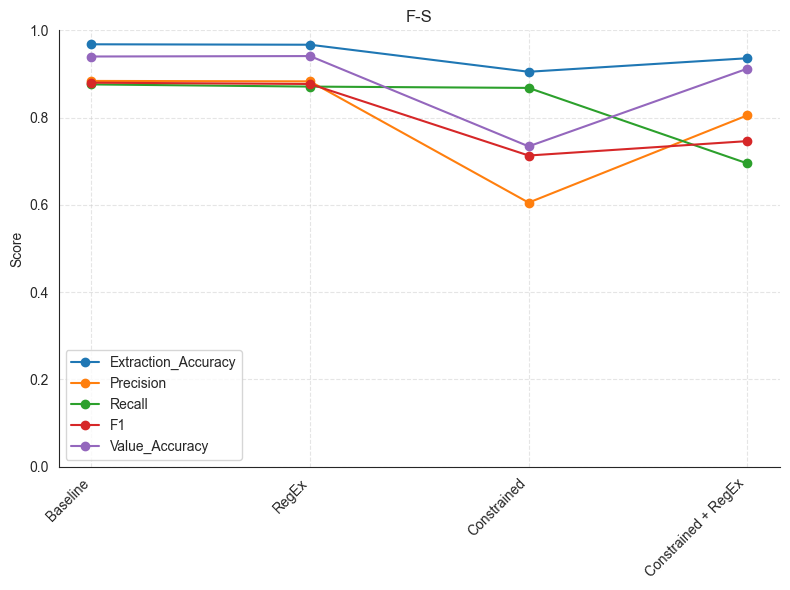

In [20]:
# Expanded order covering all setups from your table
order = [
    "Baseline",
    "RegEx",
    "Constrained",
    "Constrained + RegEx",
]

# Map each order name to the corresponding row in df_gptoss
def map_order(name):
    if name == "0-S":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 0)]
    elif name == "Baseline":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 0)]
    elif name == "F-S + Implausible":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 0)]
    elif name == "0-S + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 1)]
    elif name == "RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 1) ]
    elif name == "F-S + Implausible + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 1) ]
    elif name == "0-S Constrained":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 0) ]
    elif name == "Constrained":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 0) ]
    elif name == "F-S + Implausible Constrained":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 0) ]
    elif name == "0-S Constrained + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 1)]
    elif name == "Constrained + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 1)]
    elif name == "F-S + Implausible Constrained + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 1)]
    return pd.DataFrame()

# Prepare plotting data
plot_data = {metric: [] for metric in metrics}
for cond in order:
    subset = map_order(cond)
    for metric in metrics:
        if not subset.empty:
            plot_data[metric].append(subset[metric].values[0])
        else:
            plot_data[metric].append(None)

# Plot ablation results
plt.figure(figsize=(8, 6))
for metric in metrics:
    plt.plot(order, plot_data[metric], marker='o', label=metric)

plt.title("F-S")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
sns.despine()
plt.savefig("figures/gpt_ablation_F-S")


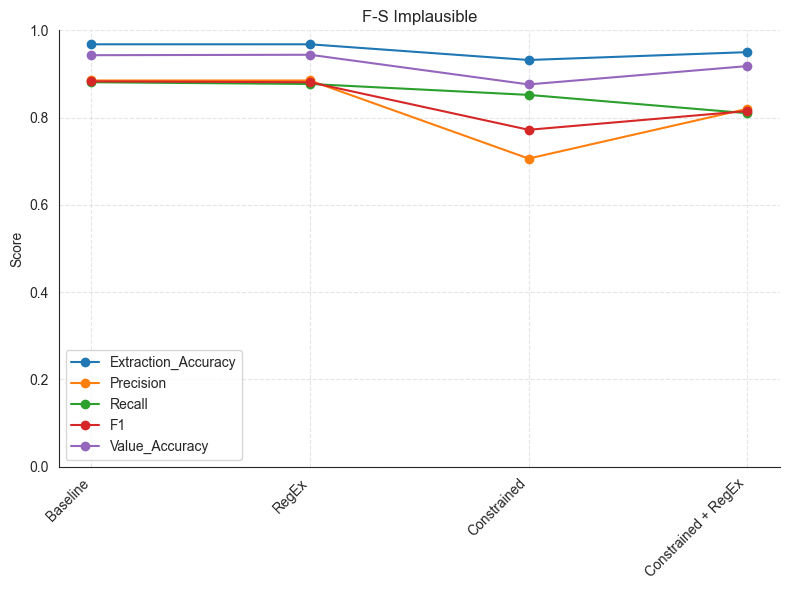

In [21]:
# Expanded order covering all setups from your table
order = [
    "Baseline",
    "RegEx",
    "Constrained",
    "Constrained + RegEx",
]

# Map each order name to the corresponding row in df_gptoss
def map_order(name):
    if name == "0-S":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 0)]
    elif name == "F-S":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 0)]
    elif name == "Baseline":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 0)]
    elif name == "0-S RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 1)]
    elif name == "F-S + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 1) ]
    elif name == "RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 0) & (df_gptoss["RegEx"] == 1) ]
    elif name == "0-S Constrained":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 0) ]
    elif name == "F-S Constrained":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 0) ]
    elif name == "Constrained":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 0) ]
    elif name == "0-S Constrained + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "0-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 1)]
    elif name == "F-S Constrained + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 1)]
    elif name == "Constrained + RegEx":
        return df_gptoss[(df_gptoss["Prompt"] == "F-shot Implausible") & (df_gptoss["Constrained"] == 1) & (df_gptoss["RegEx"] == 1)]
    return pd.DataFrame()

# Prepare plotting data
plot_data = {metric: [] for metric in metrics}
for cond in order:
    subset = map_order(cond)
    for metric in metrics:
        if not subset.empty:
            plot_data[metric].append(subset[metric].values[0])
        else:
            plot_data[metric].append(None)

# Plot ablation results
plt.figure(figsize=(8, 6))
for metric in metrics:
    plt.plot(order, plot_data[metric], marker='o', label=metric)

plt.title("F-S Implausible")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
sns.despine()
plt.savefig("figures/gpt_ablation_F-S_implausible")

<>:18: SyntaxWarning: invalid escape sequence '\+'
<>:22: SyntaxWarning: invalid escape sequence '\+'
<>:28: SyntaxWarning: invalid escape sequence '\+'
<>:33: SyntaxWarning: invalid escape sequence '\+'
<>:18: SyntaxWarning: invalid escape sequence '\+'
<>:22: SyntaxWarning: invalid escape sequence '\+'
<>:28: SyntaxWarning: invalid escape sequence '\+'
<>:33: SyntaxWarning: invalid escape sequence '\+'
/var/folders/h3/lgj1d7cx4_v84f92fb3r17_m0000gn/T/ipykernel_13583/1221850866.py:18: SyntaxWarning: invalid escape sequence '\+'
  ~df["Model"].str.contains("Constrained|\+ RegEx") &
/var/folders/h3/lgj1d7cx4_v84f92fb3r17_m0000gn/T/ipykernel_13583/1221850866.py:22: SyntaxWarning: invalid escape sequence '\+'
  df["Model"].str.contains("\+ RegEx") &
/var/folders/h3/lgj1d7cx4_v84f92fb3r17_m0000gn/T/ipykernel_13583/1221850866.py:28: SyntaxWarning: invalid escape sequence '\+'
  ~df["Model"].str.contains("\+ RegEx") &
/var/folders/h3/lgj1d7cx4_v84f92fb3r17_m0000gn/T/ipykernel_13583/122185086

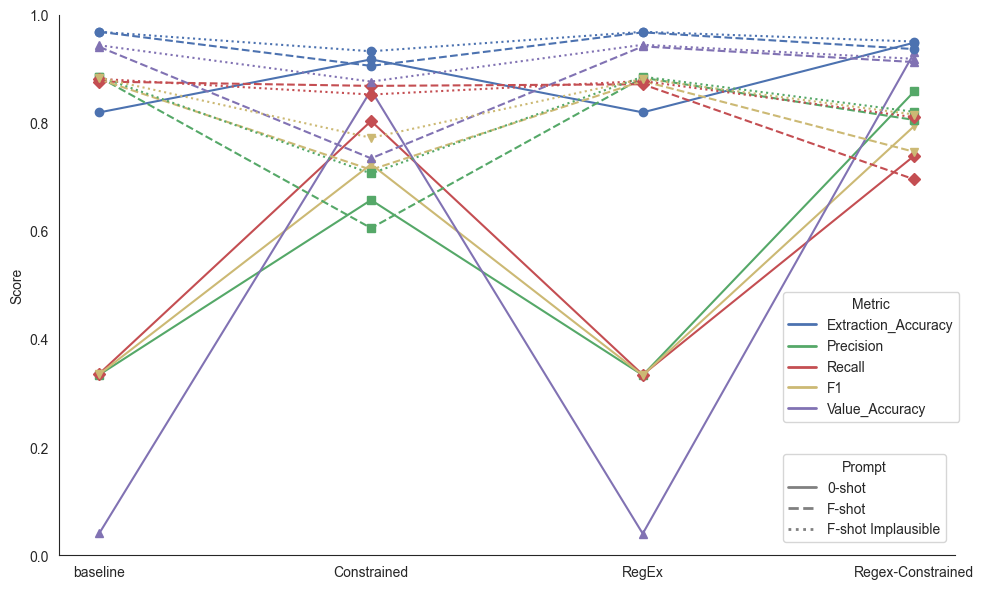

In [22]:
from matplotlib.lines import Line2D



def map_order(label, prompt):
    # Start with filtering by prompt
    df = df_gptoss[df_gptoss["Prompt"] == prompt]
    
    # Determine model prefix
    prefix = "0-S" if prompt.startswith("0-shot") else "F-S"
    
    # Determine if this is an Implausible prompt
    is_implausible = "Implausible" in prompt
    
    # Map labels to conditions
    if label == "baseline":
        return df[df["Model"].str.contains(prefix) &
                  ~df["Model"].str.contains("Constrained|\+ RegEx") &
                  ((~df["Model"].str.contains("Implausible")) if not is_implausible else df["Model"].str.contains("Implausible"))]
    elif label == "RegEx":
        return df[df["Model"].str.contains(prefix) &
                  df["Model"].str.contains("\+ RegEx") &
                  ~df["Model"].str.contains("Constrained") &
                  ((~df["Model"].str.contains("Implausible")) if not is_implausible else df["Model"].str.contains("Implausible"))]
    elif label == "Constrained":
        return df[df["Model"].str.contains(prefix) &
                  df["Model"].str.contains("Constrained") &
                  ~df["Model"].str.contains("\+ RegEx") &
                  ((~df["Model"].str.contains("Implausible")) if not is_implausible else df["Model"].str.contains("Implausible"))]
    elif label == "Regex-Constrained":
        return df[df["Model"].str.contains(prefix) &
                  df["Model"].str.contains("Constrained") &
                  df["Model"].str.contains("\+ RegEx") &
                  ((~df["Model"].str.contains("Implausible")) if not is_implausible else df["Model"].str.contains("Implausible"))]
    return pd.DataFrame()



# Colors for each metric
metric_colors = {
    "Extraction_Accuracy": "#4C72B0",
    "Precision": "#55A868",
    "Recall": "#C44E52",
    "F1": "#CCB974",
    "Value_Accuracy": "#8172B3"
}

metric_markers = {"Extraction_Accuracy": "o", 
           "Precision": "s", 
           "Recall": "D", 
           "F1": "v",
           "Value_Accuracy": "^"}

# Line styles for prompts
line_styles = {
    "0-shot": "solid",
    "F-shot": "dashed",
    "F-shot Implausible": "dotted"
}

x_labels = ["baseline", "Constrained", "RegEx", "Regex-Constrained"]


plt.figure(figsize=(10, 6))

# Plot all metrics for all prompts
for prompt in ["0-shot", "F-shot", "F-shot Implausible"]:
    for metric in metrics:
        y_vals = []
        for label in x_labels:
            subset = map_order(label, prompt)
            if not subset.empty:
                y_vals.append(subset[metric].values[0])
            else:
                y_vals.append(None)
        plt.plot(x_labels, y_vals, marker=metric_markers[metric], linestyle=line_styles[prompt], color=metric_colors[metric])

# Axes and grid
plt.ylabel("Score")
plt.ylim(0, 1)
#plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()

# Create a custom legend
# Create a custom legend
# 1. Metric colors
metric_handles = [Line2D([0], [0], color=color, lw=2) for color in metric_colors.values()]
metric_labels = list(metric_colors.keys())

# 2. Prompt line styles
prompt_handles = [Line2D([0], [0], color="gray", lw=2, linestyle=ls) for ls in line_styles.values()]
prompt_labels = list(line_styles.keys())

# Add first legend (metrics) to the axes
leg1 = plt.legend(metric_handles, metric_labels, title="Metric", loc="upper left", bbox_to_anchor=(0.8, 0.5))
plt.gca().add_artist(leg1)  # Add it manually so it stays

# Add second legend (prompt line styles) to the axes
plt.legend(prompt_handles, prompt_labels, title="Prompt", loc="upper left", bbox_to_anchor=(0.8, 0.2))


plt.tight_layout()
plt.show()


## EDA

In [23]:
groundtruth_df = pd.read_excel("data/reports_groundtruth.xlsx")
groundtruth_df.columns

Index(['id', 'Conclusões', 'Tipo', 'Tronco_Comum_FFR',
       'Descendente_Anterior_FFR', 'Circunflexa_FFR', 'Coronária_Direita_FFR',
       'Outras_artérias_FFR', 'Tronco_Comum_iFR', 'Descendente_Anterior_iFR',
       'Circunflexa_iFR', 'Coronária_Direita_iFR', 'Outras_artérias_iFR',
       'Nr_Stents_Circunflexa', 'Nr_Stents_Coronária_Direita',
       'Nr_Stents_Descendente_Anterior', 'Nr_Stents_Outras_artérias',
       'Nr_Stents_Tronco_Comum', 'Comprimento_Stents_mm_Circunflexa',
       'Comprimento_Stents_mm_Coronária_Direita',
       'Comprimento_Stents_mm_Descendente_Anterior',
       'Comprimento_Stents_mm_Outras_artérias',
       'Comprimento_Stents_mm_Tronco_Comum'],
      dtype='object')

In [24]:
values_df = groundtruth_df[['Tronco_Comum_FFR',
       'Descendente_Anterior_FFR', 'Circunflexa_FFR', 'Coronária_Direita_FFR',
       'Outras_artérias_FFR', 'Tronco_Comum_iFR', 'Descendente_Anterior_iFR',
       'Circunflexa_iFR', 'Coronária_Direita_iFR', 'Outras_artérias_iFR']]

values_df.isna().sum()

Tronco_Comum_FFR            1326
Descendente_Anterior_FFR     955
Circunflexa_FFR             1251
Coronária_Direita_FFR       1247
Outras_artérias_FFR         1328
Tronco_Comum_iFR            1310
Descendente_Anterior_iFR     622
Circunflexa_iFR             1154
Coronária_Direita_iFR       1118
Outras_artérias_iFR         1288
dtype: int64

In [25]:
values_df.shape[0]*values_df.shape[1]

13420

In [26]:
values_df.notna().sum().sum()

np.int64(1821)

In [27]:
#PErcentage of missing values 
values_df.isna().sum().sum() / values_df.shape[0]*values_df.shape[1]

np.float64(86.4307004470939)

In [28]:
values_df.notna().sum()

Tronco_Comum_FFR             16
Descendente_Anterior_FFR    387
Circunflexa_FFR              91
Coronária_Direita_FFR        95
Outras_artérias_FFR          14
Tronco_Comum_iFR             32
Descendente_Anterior_iFR    720
Circunflexa_iFR             188
Coronária_Direita_iFR       224
Outras_artérias_iFR          54
dtype: int64

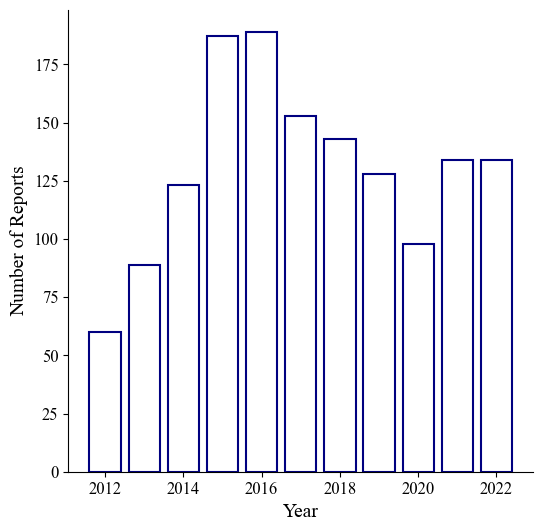

In [54]:
#Plot Dates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('../data/original_data.xlsx')
df_reports = pd.read_excel('../data/original_data_with_reports.xlsx')[["RegistoID", "Conclusões"]] #This file contains the medical reports but the remaining rows should not be used as they are not updated. We can use the reference and conclusions from the report as these did not change.

def preprocess_date_and_plot(df, df_reports):
    #Print and remove the first three rows as they are used as examples in the prompts for the LLMs
    #for conclusoes in df_reports.head(3)["Conclusões"]:
    #    print(conclusoes)
    #    print("-----")
    df_reports = df_reports.iloc[3:].reset_index(drop=True)
    
    #Pivot the original values from square to horizontal table
    df = df[["RegistoID","Data"]]
    df = df.drop_duplicates()
    
    df_final = df.merge(df_reports,on='RegistoID').merge(df[["RegistoID"]],on="RegistoID")
    df_final = df_final.drop_duplicates(subset=["RegistoID"])
    df_final["Year"] = df_final["Data"].dt.year

    # Count and sort years
    counts = df_final["Year"].value_counts().sort_index()

    plt.figure(figsize=(6, 6))

    plt.bar(
        counts.index,
        counts.values,
        color="white",
        edgecolor="navy",
        linewidth=1.5
    )

    plt.xticks([2012, 2014, 2016, 2018, 2020, 2022],fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Year",fontsize=14)
    plt.ylabel("Number of Reports",fontsize=14)

    # Optional: remove top and right spines (matplotlib equivalent of sns.despine())
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.savefig("figures/year_distribution.png", dpi=300)


preprocess_date_and_plot(df, df_reports)